In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from stop_words import get_stop_words
sns.set()
%matplotlib inline 

# Creacion de un Regresor
Para resolver el problema planteado, es necesario utilizar regresion lineal para obtener los descriptores de la imagen. Entre las multiples librerias disponibles para realizar esta tarea se opto por utilizar keras. Con keras, basta con definir una MLP donde la ultima capa no aplique ningun activador ni un soft-max. Para simplificar el contenido de este notebook, hemos implementado nuestro regresor en una libreria a parte, desde la cual importamos lo siguiente:

In [2]:
from src.regressor import Regressor, plot_metrics, r_square, rmse

Using TensorFlow backend.


Es posible ver los metodos definidos dentro al utilizar la funcion python help o accediendo directamente a la carpeta contenedora del codigo que sera adjuntada con la entrega.

Para agilizar el proceso, todos los regresores que se utilizaran en la obtencion de los indicadores seran cargados desde disco. Pero a continuacion mostraremos el procedimiento necesario para entrenar un nuevo modelo, incluyendo la verificacion de overfitting y el guardar el modelo resultante a disco.

### Calculo de los descriptores de texto
El primer paso es obtener los vectores que describen cada una de las 100000 frases contenidas en el set de entrenamiento. Se implementan dos alternativas para este procedimiento:
* CountVectorizer: ....
* TF-IDF: ...

Ambas alternativas deben ser configuradas por medio de una serie de parametros. Varias estos parametros sera priordial al momento de entrenar distintos Regressores.

Nuevamente, todo el codigo relativo a esta implementacion es creada en un codigo python externo a este notebook y debe ser importada de la siguiente manera:

In [3]:
from src.filehandler import DataHandler

En esta seccion, se creara un Regresor utilizando TF-IDF como generador de vectores. La configuracion a utilizar sera:
* ngram-range = (1, 3)
* stop-words = spanish

In [4]:
stop_words = get_stop_words('spanish')
# debemos indicar el directorio que contiene los datos y los sub-directorios que contienen cada dataset
data = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_A_data")
# y obtenemos nuestros vectores
X_train, X_test, y_train, y_test = data.get_data(method="tf-idf", stop_words=stop_words, ngram_range=(1, 3))

leyendo ./data/train_data/train_images_names.txt
leyendo ./data/train_data/train_images_vectors.bin
20000 vectores de largo 2048
leyendo ./data/test_A_data/test_A_images_names.txt
leyendo ./data/test_A_data/test_A_images_vectors.bin
1000 vectores de largo 2048
doing vectorization with TfidfVectorizer
fitting ...done
getting vectors transforms ...done


Luego creamos un regressor para este tamaño de vectores, con dos capas escondidas, cada una de 200 neuronas. Adicionalmente, se utilizada la configuracionÑ
* batch-size = 200
* loss = mean square error (MSE)
* optimizer = ADAM
* max-epochs = 100
* validation-split = 20%
* shufle = True


Adicionalmente, se implementa un Early Stopping con una paciencia de 4 epocas y que monitorea el loss de validacion, de forma que cuando deje de decrecer o empiece a aumentar, detenga el entrenamiento y evite un overfitting. Ademas, se monitorea la metrica de MAE (mean absolute error), RMSE (root mean square error) y R-square.

In [5]:
in_dim = X_train.shape[1]
out_dim = y_train.shape[1]
reg = Regressor(input_dim=in_dim, output_dim=out_dim, n=2, layer_size=200, 
                loss='mean_squared_error', optimizer='adam', metrics=['mae', rmse, r_square])
reg.build()
history = reg.fit(X_train, y_train, epochs=100, batch_size=200, validation_split=0.2, shuffle=True)

W0707 00:47:19.853078 11456 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 00:47:19.864049 11456 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 00:47:19.866134 11456 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0707 00:47:19.874137 11456 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 00:47:19.892065 11456 deprecation_wrapper.py:119] From c:\programda

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               25600     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              411648    
Total params: 477,448
Trainable params: 477,448
Non-trainable params: 0
_________________________________________________________________


W0707 00:47:20.315468 11456 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 5s 62us/step - loss: 0.6543 - mean_absolute_error: 0.4907 - rmse: 0.7969 - r_square: 0.1095 - val_loss: 0.5928 - val_mean_absolute_error: 0.4709 - val_rmse: 0.7577 - val_r_square: 0.1947
Epoch 2/100
80000/80000 [==============================] - 5s 60us/step - loss: 0.5814 - mean_absolute_error: 0.4664 - rmse: 0.7496 - r_square: 0.2086 - val_loss: 0.5754 - val_mean_absolute_error: 0.4582 - val_rmse: 0.7448 - val_r_square: 0.2183
Epoch 3/100
80000/80000 [==============================] - 5s 59us/step - loss: 0.5725 - mean_absolute_error: 0.4621 - rmse: 0.7431 - r_square: 0.2207 - val_loss: 0.5706 - val_mean_absolute_error: 0.4612 - val_rmse: 0.7416 - val_r_square: 0.2248
Epoch 4/100
80000/80000 [==============================] - 5s 59us/step - loss: 0.5691 - mean_absolute_error: 0.4605 - rmse: 0.7407 - r_square: 0.2253 - val_loss: 0.5685 - val_mean_absolute_error: 0.4646 - val_rm

Como se observa al ejecutar la celda de arriba, entrenar el modelo entrega informacion sobre las metricas al terminar cada epoca y se detiene cuando el loss deja de bajar. Es posible observar las metricas o evaluar el modelo en otro data-set, ejecutando la siguiente celda:

evaluando test
5000/5000 [==============================] - 0s 36us/step
    EVALUATION RESULTS :  
loss: 0.56
mean_absolute_error: 0.46
rmse: 0.74
r_square: 0.23


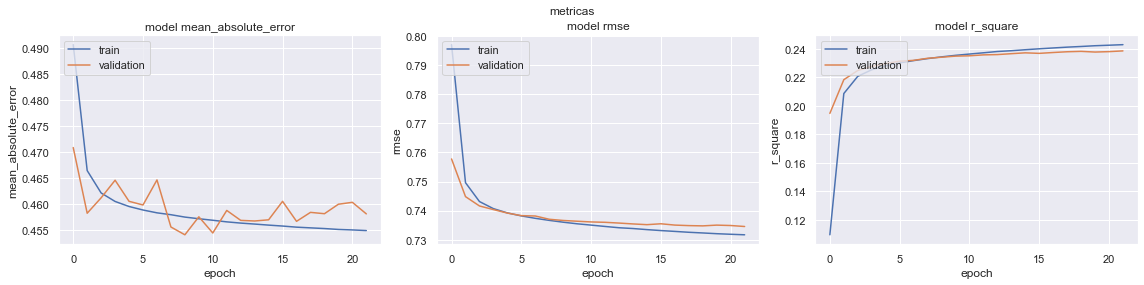

In [7]:
# graficar las metricas
reg.plot_metrics()

# evaluar el modelo
scores = reg.evaluate(X_test, y_test)

Por ultimo, el modelo debe ser guardado si se desea utilizarlo para situaciones posteriores, esto se realiza muy facilmente de la siguiente forma:

saving model to disk ... done!
loading model from disk ... done!
evaluando test
5000/5000 [==============================] - 0s 47us/step
    EVALUATION RESULTS :  
loss: 0.56
mean_absolute_error: 0.46
rmse: 0.74
r_square: 0.23


(<Figure size 1152x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000193D5F10518>,
       dtype=object))

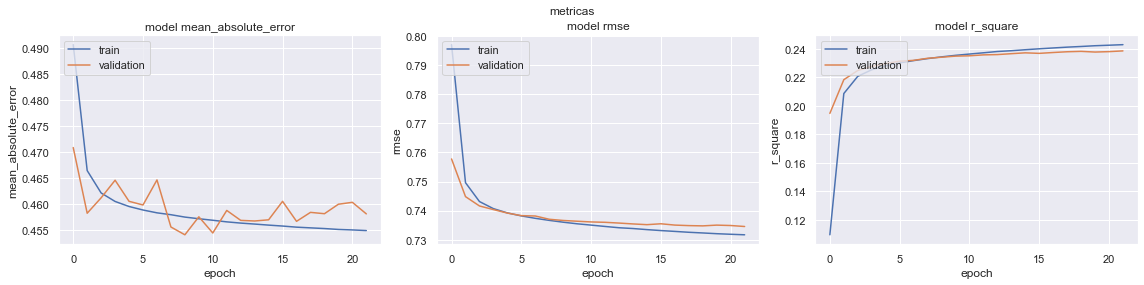

In [9]:
reg.save("test")
# se puede verificar esto al cargar el modelo en una nueva variable
reg2 = Regressor()
reg2.load("test", custom_objects={"rmse": rmse, "r_square": r_square})
# y veamos que evaluar el conjunto de test da los mismos resultados
score2 = reg2.evaluate(X_test, y_test)

# graficar las metricas
reg2.plot_metrics()

### Casos de estudio
Para este trabajo se opto por fijar una arquitectura para el regresor y estudiar diversas configuraciones en la obtencion de los descriptores de texto. La arquitectura comun para todos los casos de estudio sera la misma que fue utilizada en el ejemplo de arriba, en particular:

* capas internas:
    * fully-connected de 200 neuronas con activador ReLu
    * fully-connected de 200 neuronas con activador ReLu
* capa de salida: fully-connected de 2048 sin activador
* batch-size = 200
* loss = mean square error (MSE)
* optimizer = ADAM
* max-epochs = 100
* validation-split = 20%
* shufle = True
* Early Stopping : tolerancia de 0.005, con una paciencia de 4 epochas
* metricas monitoreadas : Mean Absolute Error, Root Mean Square Error, R-Square


Luego, los casos de estudio seran:
* Count-vectorizer con ngram_range = (1,1) y sin stop_words
* Count-vectorizer con ngram_range = (1,4) y sin stop_words
* Count-vectorizer con ngram_range = (1,4) y con stop_words de español
* TF-IDF con ngram_range = (1,1) y sin stop_words
* TF-IDF con ngram_range = (1,4) y sin stop_words
* TF-IDF con ngram_range = (1,4) y con stop_words de español


Los regresores para cada uno de estos modelos se encuentran almacenados en la carpeta /model con nombres descriptivos de cada configuracion, de forma que puedan ser cargados facilmente.

A continuacion se presentan graficos de cada uno de estos regressores para asegurar que ninguno de ellos presente overffiting.

In [ ]:
# aqui entrenare los modelos, despues esta celda desaparecera


# CV ngram (1, 1) none
X_train, X_test, y_train, y_test = data.get_data(method="count-vectorizer", stop_words=None, ngram_range=(1, 1))
